In [1]:
import requests
import pandas as pd

In [2]:
class QueryBuilder:
    def __init__(self):
        self._prefix = "https://iss.moex.com/iss/"
        self._pargs = []
        self._ext = ""
        self._args = []

    def engine(self, engine: str) -> "QueryBuilder":
        self._pargs.extend(["engines", engine])
        return self
    
    def market(self, market: str) -> "QueryBuilder":
        self._pargs.extend(["markets", market])
        return self
    
    def trades(self) -> "QueryBuilder":
        self._pargs.append("trades")
        return self
    
    def json(self) -> "QueryBuilder":
        self._ext = ".json"
        return self

    def arg(self, arg: str, val: str) -> "QueryBuilder":
        self._args.append(f"{arg}={val}")
        return self
    
    @property
    def url(self) -> str:
        q = self._prefix
        q += "/".join(self._pargs)
        q += self._ext

        if self._args:
            q += "?"
            q += "&".join(self._args)
        
        return q

QueryBuilder

__main__.QueryBuilder

In [3]:
def query_trades(
    *,
    tradeno: int = 0,
    next_trade: int = 0,
    limit: int = 5000,
    start: int = 0,
    engine: str = "stock",
    market: str = "shares",
) -> dict:
    # https://iss.moex.com/iss/reference/379
    qb = (
        QueryBuilder()
        .engine(engine)
        .market(market)
        .trades()
        .json()
        .arg("tradeno", tradeno)
        .arg("next_trade", next_trade)
        .arg("limit", limit)
        .arg("start", start)
    )

    r = requests.get(qb.url)
    r.raise_for_status()

    json = r.json()
    data = json

    return data

def trades_to_table(trades: dict) -> pd.DataFrame:
    trades = trades["trades"]

    dtypes = {
        'TRADENO': 'int64', 
        'TRADETIME': 'string', 
        'BOARDID': 'string', 
        'SECID': 'string', 
        'PRICE': 'float64', 
        'QUANTITY': 'int64', 
        'VALUE': 'float64', 
        'PERIOD': 'string', 
        'TRADETIME_GRP': 'int64', 
        'SYSTIME': 'datetime64[ns]', 
        'BUYSELL': 'string', 
        'DECIMALS': 'int32', 
        'TRADINGSESSION': 'string', 
        'TRADEDATE': 'string', 
        'TRADE_SESSION_DATE': 'string',
    }
    df = pd.DataFrame(trades["data"], columns=trades["columns"], dtype='string')
    df = df.astype(dtypes)
    df = df.set_index("TRADENO")
    return df


In [4]:
import datetime as dt
from pathlib import Path


def update_today_trades() -> int:
    today = dt.datetime.now().strftime("%Y-%m-%d")

    dataset = Path("data/trade_data")
    tdata = dataset / (f"TRADEDATE={today}")

    if tdata.exists():
        idxs = sorted(list(tdata.iterdir()))
        if len(idxs) == 0:
            last_idx = 0
            next_trade = 0
        else:
            last_idx = idxs[-1]
            last_idx = last_idx.name[len("LAST_TRADENO="):]
            last_idx = int(last_idx)
            next_trade = 1
    else:
        last_idx = 0
        next_trade = 0

    df = trades_to_table(query_trades(tradeno=last_idx, next_trade=next_trade)).sort_index()
    if len(df) == 0:
        return 0

    last_idx = df.index[-1]
    df.loc[:, "LAST_TRADENO"] = last_idx

    dataset.mkdir(exist_ok=True)
    df.to_parquet(dataset, engine="pyarrow", partition_cols=["TRADEDATE", "LAST_TRADENO"])

    return len(df)

update_today_trades

<function __main__.update_today_trades() -> int>

In [5]:
from IPython.display import clear_output

def update_today_all(retries=10):
    cr = retries
    total = 0
    err_hist = []
    while True:
        try:
            l = update_today_trades()
            total += l
            print(f"Added {total} rows")
            if l == 0:
                break
            cr = retries
        except Exception as e:
            err_hist.append(e)
            cr -= 1
            if cr <= 0:
                print("NO RETRIES ARE LEFT!")
                break

    clear_output()

    if len(err_hist) > 0:
        print("=== ERRORS ==")
        for err in err_hist:
            print(err)
        print()

    print(f"=== TOTAL ADDED ===")
    print(total)

update_today_all

<function __main__.update_today_all(retries=10)>

In [16]:
update_today_all()

=== TOTAL ADDED ===
0


In [17]:
df = pd.read_parquet("data/trade_data", engine="pyarrow")
print(len(df))

2845298


In [18]:
df.head()

,TRADETIME,BOARDID,SECID,PRICE,QUANTITY,VALUE,PERIOD,TRADETIME_GRP,SYSTIME,BUYSELL,DECIMALS,TRADINGSESSION,TRADE_SESSION_DATE,TRADEDATE,LAST_TRADENO
TRADENO,,,,,,,,,,,,,,,
14918687780,06:54:04,SMAL,MTSS,215.300,4,861.20,N,654,2025-12-10 06:54:10,B,2,0,2025-12-10,2025-12-10,14918692961
14918687795,06:57:04,SMAL,MOEX,176.000,1,176.00,N,657,2025-12-10 06:57:04,B,2,0,2025-12-10,2025-12-10,14918692961
14918687803,06:59:31,TQBR,APTK,8.524,10,852.40,S,659,2025-12-10 06:59:31,B,3,0,2025-12-10,2025-12-10,14918692961
14918687804,06:59:31,TQBR,APTK,8.524,6,511.44,S,659,2025-12-10 06:59:31,B,3,0,2025-12-10,2025-12-10,14918692961
14918687805,06:59:31,TQBR,APTK,8.524,46,3921.04,S,659,2025-12-10 06:59:31,B,3,0,2025-12-10,2025-12-10,14918692961


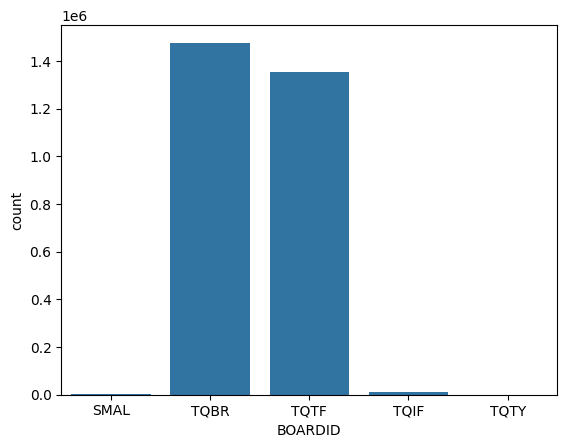

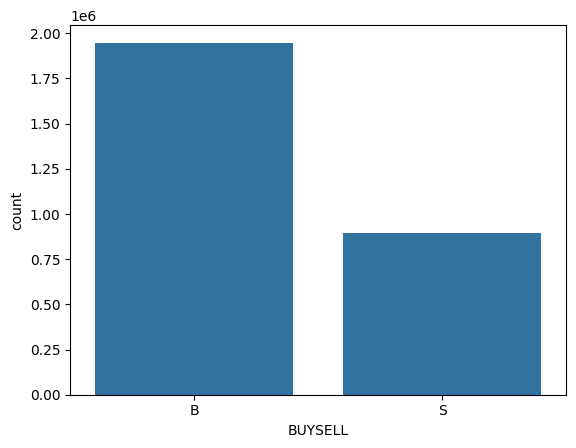

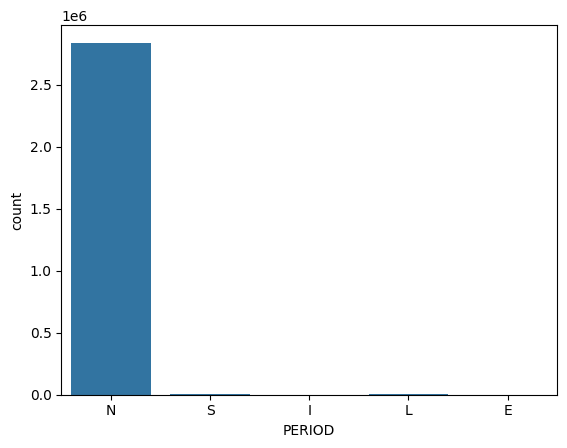

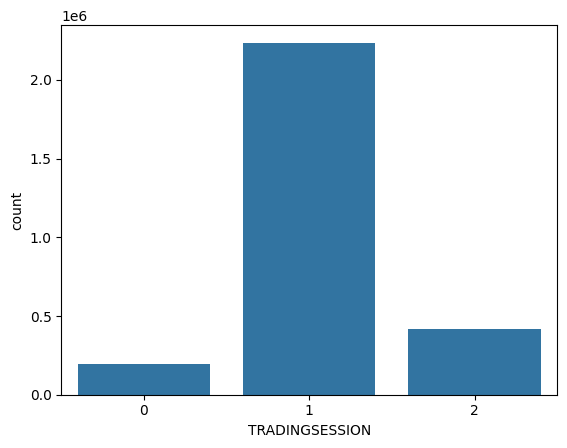

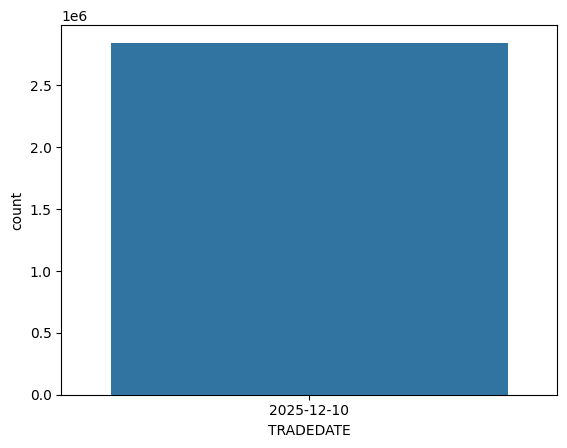

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.countplot(df, x="BOARDID")
plt.show()

sns.countplot(df, x="BUYSELL")
plt.show()

sns.countplot(df, x="PERIOD")
plt.show()

sns.countplot(df, x="TRADINGSESSION")
plt.show()

sns.countplot(df, x="TRADEDATE")
plt.show()

In [20]:
print(df.TRADETIME.max())

23:43:46
